# Author: Violet Huang, Ryan Liang

# Prepare Dependencies

In [12]:
%%configure -f
{
    "conf": {
        "spark.jars.packages": "com.johnsnowlabs.nlp:spark-nlp_2.12:4.3.1",
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type": "native",
        "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv",
        "spark.executor.memory": "4g"   
    }
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1685118627020_0005,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1685118627020_0003,pyspark,idle,Link,Link,
3,application_1685118627020_0005,pyspark,idle,Link,Link,✔


In [ ]:
sc.install_pypi_package('spark-nlp')
sc.install_pypi_package('pickle')
sc.install_pypi_package('numpy')

# 1. Generating RoBerta Embeddings with Spark NLP in Spark Sessoin

In [14]:
# For general Spark
from pyspark.sql import SparkSession

# For SparkNLP
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

# For PySpark MLlib
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, Tokenizer, HashingTF, IDF, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# In case you need to handle data types
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
data = spark.read.parquet('s3://newemrbuckey2/book_info.parquet')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
data = data.withColumnRenamed('imageLinks.smallThumbnail', 'imageLinks_smallThumbnail')
data = data.withColumnRenamed('imageLinks.thumbnail', 'imageLinks_thumbnail')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import sparknlp

documentAssembler = DocumentAssembler() \
.setInputCol("description") \
.setOutputCol("document")

tokenizer = Tokenizer() \
.setInputCols("document") \
.setOutputCol("token")

embeddings = RoBertaEmbeddings.pretrained("roberta_embeddings_distilroberta_base","en") \
.setInputCols(["document", "token"]) \
.setOutputCol("embeddings")

pipeline = Pipeline(stages=[documentAssembler, tokenizer, embeddings])
result = pipeline.fit(data).transform(data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

roberta_embeddings_distilroberta_base download started this may take some time.
Approximate size to download 294.5 MB
[OK!]

In [18]:
sc.install_pypi_package("pandas==1.0.5")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/af/f3/683bf2547a3eaeec15b39cef86f61e921b3b187f250fcd2b5c5fb4386369/pandas-1.0.5-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl

In [20]:
listValues = result.select("embeddings").rdd.map(lambda row: row[0]).collect()

In [21]:
import boto3
s3 = boto3.client('s3')

In [24]:
import pickle as pkl
pickle_object = pkl.dumps(listValues)
response = s3.put_object(
    Body=pickle_object,
    Bucket='hleung-assignment3',
    Key='embeddings.pickle'
)

# 2. Dimension Reduction and Clustering with cuML

This session is run with another python session (not a Spark runtime), so the resources are reloaded from the Buckets.

In [1]:
import boto3
import os
import json
import pandas as pd
import numpy as np
import pickle as pkl

In [26]:
book_info = pd.read_parquet('s3://hleung-assignment3/book_info.parquet', engine = 'pyarrow')

In [41]:
book_info = book_info[book_info['description'] != 'None']
raw_text = list(book_info['description'])

In [43]:
response = s3.get_object(Bucket='hleung-assignment3', Key='embeddings.pickle')
body = response['Body'].read()
embeddings = pkl.loads(body)

In [46]:
embeddings = np.array(embeddings)
embeddings

array([[ 0.02784006,  0.07538308,  0.10991567, ..., -0.0511117 ,
         0.03425498,  0.06233433],
       [-0.03425867,  0.11978679,  0.11524409, ..., -0.0742497 ,
         0.01568413,  0.04208694],
       [ 0.05607674,  0.08796979,  0.0205799 , ..., -0.07605164,
         0.06563022,  0.0646955 ],
       ...,
       [ 0.01026644,  0.09844184,  0.04236247, ..., -0.10537211,
         0.04477907,  0.02297609],
       [ 0.00757203,  0.07890654,  0.12018888, ..., -0.0350088 ,
         0.04538227,  0.00372668],
       [ 0.04130852,  0.13839261,  0.11578551, ..., -0.1324808 ,
         0.02066202,  0.02001444]], dtype=float32)

In [50]:
import cuml
import pickle as pkl

In [60]:
embedding_cluster = cuml.manifold.UMAP(n_components=20, min_dist=0.0).fit_transform(embeddings)
embedding_vis = cuml.manifold.UMAP(n_components=2, min_dist=0.0).fit_transform(embeddings)

In [82]:
clusterer = cuml.cluster.hdbscan.HDBSCAN(min_cluster_size=100, metric='euclidean', prediction_data=True).fit(embedding_cluster)
list_labels = clusterer.labels_

with open('list_labels.pickle', 'wb') as f:
    pkl.dump(list_labels, f)

In [91]:
from collections import Counter
Counter(list_labels)

Counter({-1: 3960,
         3: 1317,
         7: 347,
         1: 192,
         6: 259,
         4: 686,
         5: 289,
         0: 337,
         2: 181})

Under BERTopic with HDBSCAN, we found 8 valid text clusters.

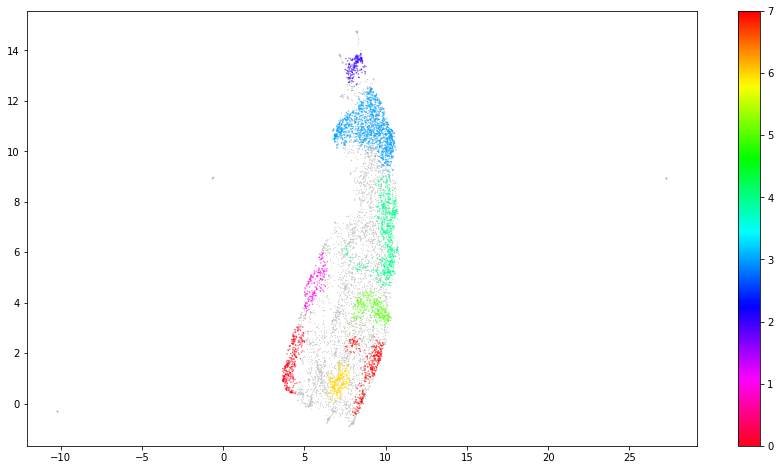

In [101]:
import matplotlib.pyplot as plt

result = pd.DataFrame(embedding_vis.embedding_, columns=['x', 'y'])
result['labels'] = list_labels
# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 8))
outliers = result.loc[result['labels'] == -1, :]
clustered = result.loc[result['labels'] != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.1, cmap='hsv_r')
plt.colorbar()

# 3. Visualization of BERTopics

In [2]:
import pandas as pd
import pickle as pkl

book_info = pd.read_parquet('book_info.parquet', engine = 'pyarrow')
book_info = book_info[book_info['description'] != 'None']
raw_text = list(book_info['description'])

with open('list_labels.pickle', 'rb') as f:
    list_labels = pkl.load(f)

In [13]:
from stop_words import get_stop_words
sw = get_stop_words('en')

def c_tf_idf(documents,m,ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range,stop_words= sw).fit(documents)  
    t = count.transform(documents).toarray()  
    w = t.sum(axis=1)  
    tf = np.divide(t.T, w)  
    sum_t = t.sum(axis=0)  
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)  
    tf_idf = np.multiply(tf, idf)  
    return tf_idf, count

def extract_topic_sizes(df):      
    topic_sizes = (df.groupby(['Topic']).Doc.count().reset_index().rename({"Topic": "Topic", "Doc": "Size"}, axis='columns').sort_values("Size", ascending=False))  
    return topic_sizes

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):      
    words = count.get_feature_names()      
    labels = list(docs_per_topic.Topic)      
    tf_idf_transposed = tf_idf.T      
    indices = tf_idf_transposed.argsort()[:, -n:]     
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}      
    return top_n_words

Now clean the data

In [16]:
import nltk
import string
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

processed_text = [text.lower() for text in raw_text]
processed_text = ["".join([char for char in text if char not in string.punctuation]) for text in processed_text]
processed_text = [word_tokenize(text) for text in processed_text]
processed_text = [[word for word in text if word not in sw] for text in processed_text]
processed_text = [[stemmer.stem(word) for word in text] for text in processed_text]

In [29]:
finished_text = [" ".join(text) for text in processed_text]
docs_df = pd.DataFrame(pd.Series(finished_text), columns=["Doc"])
docs_df['Topic'] = list_labels
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
len(docs_per_topic.Doc.tolist())

9

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m = len(finished_text))   
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)   
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes

c:\Users\aruba\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,Topic,Size
0,-1,3960
4,3,1317
5,4,686
8,7,347
1,0,337
6,5,289
7,6,259
2,1,192
3,2,181


In [35]:
from pprint import pprint
for i in top_n_words.keys():
    if i == -1:
        continue    
    print('Most 20 Important words in TOPIC {} :'.format(i))    
    pprint(top_n_words[i])    
    pprint('***'*20)

Most 20 Important words in TOPIC 0 :
[('york', 0.012568924250010912),
 ('love', 0.010686453956835526),
 ('novel', 0.01025327379302722),
 ('stori', 0.010109169117590654),
 ('time', 0.009861628347936057),
 ('bestsel', 0.00984597457634269),
 ('murder', 0.009625113934753548),
 ('one', 0.009462978907869948),
 ('famili', 0.008716895714196505),
 ('year', 0.008489680252085312),
 ('secret', 0.0079159735800635),
 ('best', 0.0071450828728773196),
 ('mysteri', 0.007074560467434552),
 ('life', 0.006871594438962023),
 ('mother', 0.006698413833664063),
 ('author', 0.006307538546278646),
 ('young', 0.006207280186106829),
 ('thriller', 0.00590280704273566),
 ('man', 0.0058966983845604995),
 ('father', 0.005866089888665662),
 ('woman', 0.005823895710132186),
 ('home', 0.005799464972234205),
 ('name', 0.005655482295242052),
 ('never', 0.005637683389274398),
 ('friend', 0.00562510593561291),
 ('new', 0.005525502672309004),
 ('two', 0.005474581664253973),
 ('come', 0.005437561282430163),
 ('killer', 0.0053